# Model Training and Evaluating it

**Description:**
This notebook creates various models and evaulates them as needed.

In [1]:
#Setting everything up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras import layers, models

sys.path.append(os.path.abspath(os.path.join('..')))
from scripts.data_process import make_supervised_frame, time_series_split
from scripts.data_modeling import compute_regression_metrics, directional_accuracy, make_lstm_sequences

np.random.seed(42)
tf.random.set_seed(42)
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

2025-12-10 01:00:04.138126: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-10 01:00:04.138576: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-10 01:00:04.199951: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-12-10 01:00:06.801074: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-10 01:00:06.802886: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
#Loading data
df = pd.read_csv("../data/sp500.csv", index_col = "Date", parse_dates = True)

df_sup = make_supervised_frame(df, target_col="LogReturn", horizon=1, lags=3)

df_sup.head()

,Close,High,Low,Open,Volume,MA10,MA50,EMA10,EMA50,Return,LogReturn,Volatility20,Momentum10,MACD,MACD_signal,y,LogReturn_lag1,LogReturn_lag2,LogReturn_lag3
Date,,,,,,,,,,,,,,,,,,,
1990-03-13,336.000000,338.670013,335.359985,338.670013,145440000,336.166000,335.755001,335.943020,337.536140,-0.007884,-0.007915,0.007626,5.739990,0.922821,-0.212164,0.002586,0.002187,-0.006901,0.009805
1990-03-14,336.869995,337.630005,334.929993,336.000000,145060000,336.663998,335.298601,336.111561,337.510017,0.002589,0.002586,0.007623,4.979980,0.965092,0.023287,0.003556,-0.007915,0.002187,-0.006901
1990-03-15,338.070007,338.910004,336.869995,336.869995,144410000,337.197000,334.884801,336.467642,337.531977,0.003562,0.003556,0.007632,5.330017,1.082940,0.235218,0.011295,0.002586,-0.007915,0.002187
1990-03-16,341.910004,341.910004,338.070007,338.070007,222520000,337.834000,334.609601,337.457163,337.703664,0.011359,0.011295,0.007797,6.369995,1.469254,0.482025,0.004727,0.003556,0.002586,-0.007915
1990-03-19,343.529999,343.760010,339.119995,341.910004,142300000,338.813000,334.436201,338.561315,337.932148,0.004738,0.004727,0.007628,9.790009,1.884409,0.762502,-0.005722,0.011295,0.003556,0.002586


In [3]:
df_train, df_val, df_test = time_series_split(df_sup, train_frac=0.6, val_frac=0.2)

feature_cols = [c for c in df_sup.columns if c !=["y"]]

X_train, y_train = df_train[feature_cols], df_train["y"]
X_val, y_val = df_val[feature_cols], df_val["y"]
X_test, y_test = df_test[feature_cols], df_test["y"]

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Train size: 5401
Val size: 1800
Test size: 1801


In [4]:
#baseline
y_test_naive = df_test["LogReturn_lag1"]  

baseline_metrics = compute_regression_metrics(y_test, y_test_naive)
baseline_dir_acc = directional_accuracy(y_test, y_test_naive)

print("Naive baseline metrics:", baseline_metrics)
print("Naive baseline directional accuracy:", baseline_dir_acc)

Naive baseline metrics: {'RMSE': np.float64(0.016940516181126818), 'MAE': 0.011609508629903469, 'MAPE': np.float64(55028649.37670717), 'R2': -0.7663663344574858}
Naive baseline directional accuracy: 0.5091615769017213


In [5]:
# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_val_lr = linreg.predict(X_val)
y_test_lr = linreg.predict(X_test)

lr_val_metrics = compute_regression_metrics(y_val, y_val_lr)
lr_test_metrics = compute_regression_metrics(y_test, y_test_lr)
lr_dir_acc = directional_accuracy(y_test, y_test_lr)

print("Linear Regression – Validation Metrics:", lr_val_metrics)
print("Linear Regression – Test Metrics:", lr_test_metrics)
print(f"Linear Regression – Directional Accuracy: {lr_dir_acc:.2%}")

Linear Regression – Validation Metrics: {'RMSE': np.float64(7.178125137080271e-08), 'MAE': 5.83498141703862e-08, 'MAPE': np.float64(268.03066388685716), 'R2': 0.9999999999294417}
Linear Regression – Test Metrics: {'RMSE': np.float64(1.9145641052797167e-07), 'MAE': 1.4115658117593998e-07, 'MAPE': np.float64(626.2626441486011), 'R2': 0.9999999997743854}
Linear Regression – Directional Accuracy: 100.00%


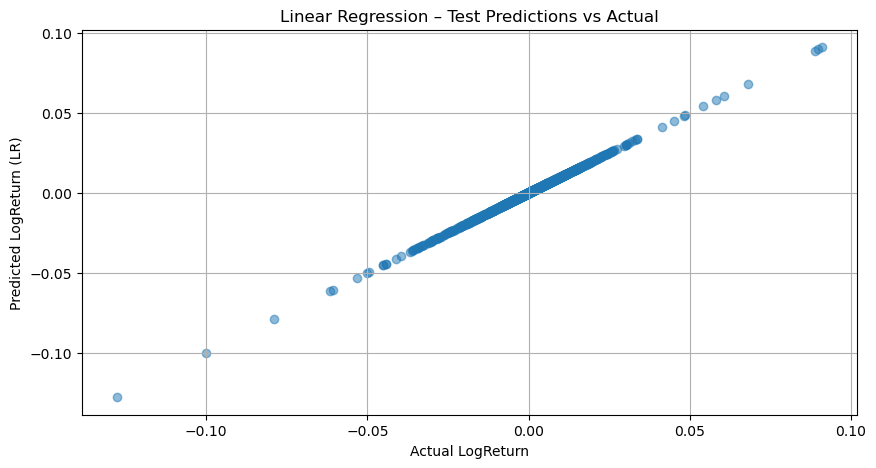

In [6]:
plt.scatter(y_test, y_test_lr, alpha=0.5)
plt.xlabel("Actual LogReturn")
plt.ylabel("Predicted LogReturn (LR)")
plt.title("Linear Regression – Test Predictions vs Actual")
plt.savefig("../images/LR.png")
plt.show()

In [7]:
rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42)
rf.fit(X_train, y_train)

y_val_rf = rf.predict(X_val)
y_test_rf = rf.predict(X_test)

rf_val_metrics = compute_regression_metrics(y_val, y_val_rf)
rf_test_metrics = compute_regression_metrics(y_test, y_test_rf)
rf_dir_acc = directional_accuracy(y_test, y_test_rf)

print("Random Forest – validation metrics:", rf_val_metrics)
print("Random Forest – test metrics:", rf_test_metrics)
print("Random Forest – test directional accuracy:", rf_dir_acc)

Random Forest – validation metrics: {'RMSE': np.float64(3.989333611068483e-05), 'MAE': 8.731841109436996e-06, 'MAPE': np.float64(50055.65107283472), 'R2': 0.9999782064824432}
Random Forest – test metrics: {'RMSE': np.float64(0.0011719469383807014), 'MAE': 8.215782319605255e-05, 'MAPE': np.float64(404318.2722217325), 'R2': 0.9915463668404144}
Random Forest – test directional accuracy: 0.9994447529150472


/home/jovyan/.local/share/envs/final-group13/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jovyan/.local/share/envs/final-group13/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jovyan/.local/share/envs/final-group13/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/home/jovyan/.local/share/envs/final-group13/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/jovyan/.local/share/envs/final-group13/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA metrics (val+test window): {'RMSE': np.float64(0.010885095016858535), 'MAE': 0.007145005319635196, 'MAPE': np.float64(34330705.82097801), 'R2': -0.0008942902664539343}
ARIMA directional accuracy: 0.5456563974465723


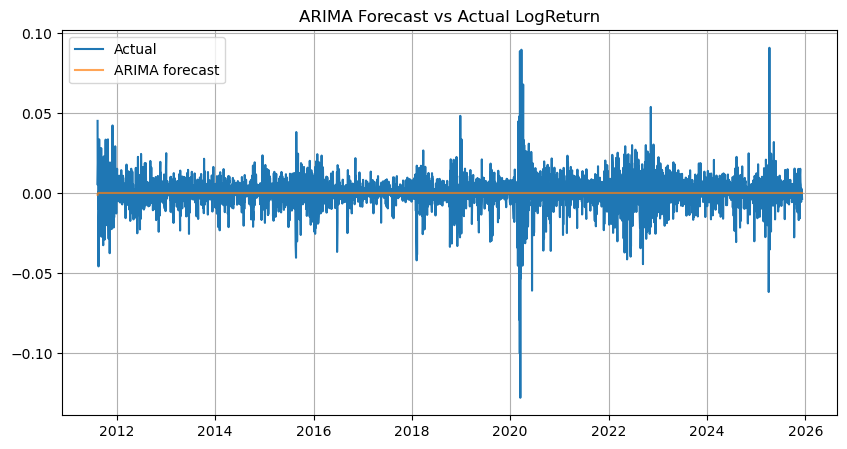

In [8]:
# 10. ARIMA baseline (simplified, univariate)


# We'll model LogReturn as a univariate series
logret_series = df["LogReturn"].dropna()

# Align with df_sup range (so we're forecasting over the same overall period)
logret_aligned = logret_series.loc[df_sup.index]

train_end_idx = df_train.index[-1]
val_end_idx = df_val.index[-1]

logret_train = logret_aligned.loc[:train_end_idx]
logret_val = logret_aligned.loc[train_end_idx:val_end_idx]
logret_test = logret_aligned.loc[val_end_idx:]

# Fit a simple ARIMA(1,0,1) on the training portion
arima_model = ARIMA(logret_train, order=(1, 0, 1))
arima_result = arima_model.fit()

# Forecast over validation + test window
n_forecast = len(logret_val) + len(logret_test)
arima_forecast = arima_result.forecast(steps=n_forecast)

# Take the last n_forecast actual values to compare against
logret_val_test = logret_aligned.iloc[-n_forecast:]

# --- Clean and align for metrics (avoid NaNs) ---

# Put both into arrays
y_true = logret_val_test.to_numpy()
y_pred = np.asarray(arima_forecast)

# In case lengths differ for any reason, clip to the shorter one
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

# Drop any NaNs that might still be present
mask = (~np.isnan(y_true)) & (~np.isnan(y_pred))
y_true_clean = y_true[mask]
y_pred_clean = y_pred[mask]

# Compute metrics
arima_metrics = compute_regression_metrics(y_true_clean, y_pred_clean)
arima_dir_acc = directional_accuracy(y_true_clean, y_pred_clean)

print("ARIMA metrics (val+test window):", arima_metrics)
print("ARIMA directional accuracy:", arima_dir_acc)

# Plot actual vs forecast on the same time index
plot_index = logret_val_test.index[:len(y_true_clean)]
plt.plot(plot_index, y_true_clean, label="Actual")
plt.plot(plot_index, y_pred_clean, label="ARIMA forecast", alpha=0.7)
plt.legend()
plt.title("ARIMA Forecast vs Actual LogReturn")
plt.savefig("../images/ARIMA.png")
plt.show()

In [9]:
#LTSM Data Prep
tf.random.set_seed(42)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

SEQ_LEN = 30
X_train_lstm, y_train_lstm = make_lstm_sequences(X_train_sc, y_train.values, SEQ_LEN)
X_val_lstm, y_val_lstm = make_lstm_sequences(X_val_sc, y_val.values, SEQ_LEN)
X_test_lstm, y_test_lstm = make_lstm_sequences(X_test_sc, y_test.values, SEQ_LEN)

Epoch 1/15


2025-12-10 01:00:27.758075: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


  1/168 ━━━━━━━━━━━━━━━━━━━━ 4:18 2s/step - loss: 0.0659

  6/168 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0519

 12/168 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0434

 18/168 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0383

 24/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0349 

 30/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0322

 36/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0301

 42/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0284

 48/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0269

 54/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0257

 60/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0246

 66/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0236

 72/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0227

 78/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0219

 84/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0212

 90/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0205

 96/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0199

102/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0193

108/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0188

114/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0183

120/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0179

126/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0174

132/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0170

138/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166

144/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163

150/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0159

157/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0156

163/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0153

168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0071 - val_loss: 2.7630e-04


Epoch 2/15


  1/168 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0015

  7/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 

 13/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020

 19/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020

 25/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019

 31/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019

 37/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018

 43/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018

 49/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018

 55/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018

 61/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018

 67/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017

 73/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017

 79/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017

 85/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017

 91/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017

 97/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017

103/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016

109/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016

115/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016

121/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016

127/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016

133/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016

139/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016

145/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015

151/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015

157/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015

163/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015

168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0011 - val_loss: 1.3414e-04


Epoch 3/15


  1/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 6.7609e-04

  7/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.5495e-04 

 13/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.2350e-04

 19/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.9969e-04

 25/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.9050e-04

 31/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.8531e-04

 37/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.8148e-04

 43/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7856e-04

 49/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7763e-04

 55/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7576e-04

 61/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7458e-04

 67/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7229e-04

 73/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7041e-04

 79/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6839e-04

 85/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6559e-04

 91/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6239e-04

 97/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5863e-04

103/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5498e-04

109/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5124e-04

115/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4737e-04

121/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4362e-04

127/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3986e-04

133/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3634e-04

139/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3279e-04

145/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2934e-04

151/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2599e-04

157/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2266e-04

163/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.1934e-04

168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.2956e-04 - val_loss: 8.0141e-05


Epoch 4/15


  1/168 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 4.4027e-04

  7/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.1018e-04 

 13/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9620e-04

 19/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9031e-04

 25/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9210e-04

 31/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9565e-04

 37/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9872e-04

 43/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0290e-04

 49/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0694e-04

 55/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.1017e-04

 61/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1593e-04

 67/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1909e-04

 73/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2113e-04

 79/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2290e-04

 85/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2409e-04

 91/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2467e-04

 97/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2449e-04

103/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2414e-04

109/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2380e-04

115/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2334e-04

121/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2278e-04

127/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2203e-04

133/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2110e-04

139/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2002e-04

145/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1889e-04

151/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1767e-04

157/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1646e-04

163/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1521e-04

168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.7602e-04 - val_loss: 6.9167e-05


Epoch 5/15


  1/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 4.9068e-04

  7/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1018e-04 

 13/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9280e-04

 19/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9199e-04

 25/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8865e-04

 31/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8467e-04

 37/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8300e-04

 43/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8519e-04

 49/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8850e-04

 55/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9163e-04

 61/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9433e-04

 67/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9620e-04

 73/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9711e-04

 79/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9758e-04

 85/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9776e-04

 91/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9754e-04

 97/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9693e-04

103/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9628e-04

109/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9567e-04

115/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9505e-04

121/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9451e-04

127/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9395e-04

133/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9327e-04

139/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9265e-04

144/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9217e-04

150/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9152e-04

156/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9088e-04

162/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9026e-04

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8965e-04

168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.7244e-04 - val_loss: 6.8015e-05


Epoch 6/15


  1/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 2.5459e-04

  7/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3608e-04 

 13/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2994e-04

 19/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3191e-04

 25/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3113e-04

 31/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2987e-04

 37/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2966e-04

 43/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2930e-04

 49/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2900e-04

 55/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2934e-04

 61/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2971e-04

 67/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2983e-04

 73/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2962e-04

 79/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2940e-04

 85/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2920e-04

 91/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2880e-04

 97/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2824e-04

103/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2771e-04

109/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2734e-04

115/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2711e-04

121/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2699e-04

127/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2677e-04

133/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2652e-04

139/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2623e-04

145/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2600e-04

151/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2578e-04

157/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2555e-04

163/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2537e-04

168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.2120e-04 - val_loss: 7.0077e-05


Epoch 7/15


  1/168 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 2.9188e-04

  6/168 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3806e-04

 12/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3674e-04 

 18/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3599e-04

 24/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3220e-04

 30/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2813e-04

 36/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2600e-04

 42/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2464e-04

 48/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2352e-04

 54/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2263e-04

 60/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2212e-04

 66/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2106e-04

 72/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1992e-04

 78/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1896e-04

 84/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1803e-04

 90/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1706e-04

 96/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1600e-04

102/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1516e-04

108/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1454e-04

114/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1403e-04

120/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1367e-04

126/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1335e-04

132/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1301e-04

137/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1270e-04

143/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1238e-04

149/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1204e-04

155/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1168e-04

161/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1134e-04

167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1101e-04

168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.0142e-04 - val_loss: 7.3925e-05


Epoch 8/15


  1/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 2.5238e-04

  7/168 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8993e-04

 13/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8659e-04 

 19/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8877e-04

 25/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8877e-04

 31/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8923e-04

 37/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9008e-04

 43/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9012e-04

 49/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9001e-04

 55/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9023e-04

 61/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9125e-04

 67/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9170e-04

 73/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9170e-04

 79/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9157e-04

 85/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9143e-04

 91/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9112e-04

 97/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9069e-04

103/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9035e-04

109/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9016e-04

115/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9009e-04

121/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9014e-04

127/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9018e-04

133/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9023e-04

139/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9022e-04

145/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9021e-04

151/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9020e-04

157/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9019e-04

163/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9015e-04

168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.8843e-04 - val_loss: 7.0693e-05


Epoch 9/15


  1/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 3.2748e-04

  7/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2604e-04 

 13/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.0402e-04

 19/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9686e-04

 25/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9264e-04

 31/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8949e-04

 37/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8783e-04

 43/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8631e-04

 49/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8562e-04

 55/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8567e-04

 61/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8569e-04

 67/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8510e-04

 73/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8433e-04

 78/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8369e-04

 84/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8290e-04

 90/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8207e-04

 96/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8128e-04

102/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8059e-04

108/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8011e-04

114/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7975e-04

120/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7961e-04

126/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7949e-04

132/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7934e-04

138/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7917e-04

144/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7904e-04

150/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7888e-04

156/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7870e-04

162/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7857e-04

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7850e-04

168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.7658e-04 - val_loss: 6.9025e-05


Epoch 10/15


  1/168 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 2.5594e-04

  7/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8167e-04 

 13/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7392e-04

 19/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7335e-04

 25/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7149e-04

 31/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7062e-04

 37/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7073e-04

 43/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7076e-04

 49/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7074e-04

 55/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7107e-04

 61/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7178e-04

 67/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7201e-04

 73/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7191e-04

 79/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7172e-04

 85/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7146e-04

 91/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7104e-04

 97/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7057e-04

103/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7022e-04

109/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7007e-04

115/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7015e-04

121/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7036e-04

127/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7056e-04

134/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7067e-04

141/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7073e-04

147/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7082e-04

153/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7087e-04

159/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7094e-04

165/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7098e-04

168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.7079e-04 - val_loss: 6.7987e-05


Epoch 11/15


  1/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 3.4878e-04

  7/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1028e-04 

 13/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8907e-04

 19/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8030e-04

 25/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7460e-04

 31/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7076e-04

 37/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6925e-04

 43/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6776e-04

 49/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6662e-04

 55/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6605e-04

 61/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6613e-04

 67/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6595e-04

 73/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6565e-04

 79/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6531e-04

 85/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6494e-04

 91/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6446e-04

 97/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6397e-04

103/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6365e-04

109/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6353e-04

115/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6359e-04

121/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6382e-04

127/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6396e-04

133/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6404e-04

139/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6407e-04

145/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6411e-04

151/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6411e-04

157/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6410e-04

163/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6407e-04

168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.6282e-04 - val_loss: 6.9519e-05


Epoch 12/15


  1/168 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1.8450e-04

  7/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4972e-04 

 13/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4701e-04

 19/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4861e-04

 25/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4878e-04

 31/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4870e-04

 37/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4944e-04

 43/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4994e-04

 49/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5040e-04

 55/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5123e-04

 61/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5264e-04

 67/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5336e-04

 73/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5372e-04

 79/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5392e-04

 85/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5398e-04

 91/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5390e-04

 97/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5377e-04

103/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5375e-04

109/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5391e-04

115/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5422e-04

121/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5464e-04

127/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5502e-04

132/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5525e-04

138/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5549e-04

144/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5575e-04

150/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5599e-04

156/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5621e-04

162/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5642e-04

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5660e-04

168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.6101e-04 - val_loss: 6.8521e-05


Epoch 13/15


  1/168 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 2.2210e-04

  7/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6654e-04 

 13/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6005e-04

 19/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5796e-04

 25/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5574e-04

 31/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5437e-04

 37/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5426e-04

 43/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5402e-04

 49/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5375e-04

 55/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5396e-04

 62/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5450e-04

 68/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5447e-04

 74/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5432e-04

 80/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5421e-04

 86/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5397e-04

 92/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5371e-04

 98/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5345e-04

104/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5328e-04

110/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5325e-04

116/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5343e-04

122/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5369e-04

128/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5386e-04

134/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5394e-04

140/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5398e-04

146/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5403e-04

152/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5405e-04

158/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5408e-04

164/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5410e-04

168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5406e-04 - val_loss: 6.7993e-05


Epoch 14/15


  1/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 2.2555e-04

  7/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6614e-04 

 13/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5605e-04

 19/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5096e-04

 25/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4884e-04

 31/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4801e-04

 37/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4815e-04

 43/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4804e-04

 49/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4807e-04

 55/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4855e-04

 61/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4924e-04

 67/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4950e-04

 73/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4962e-04

 79/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4968e-04

 85/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4964e-04

 91/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4945e-04

 97/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4928e-04

103/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4920e-04

109/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4931e-04

115/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4955e-04

121/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4992e-04

127/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5022e-04

133/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5047e-04

139/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5068e-04

145/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5090e-04

151/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5107e-04

157/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5121e-04

163/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5136e-04

168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5460e-04 - val_loss: 6.8454e-05


Epoch 15/15


  1/168 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 1.8362e-04

  7/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4532e-04 

 13/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4250e-04

 19/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4203e-04

 25/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4099e-04

 31/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4012e-04

 37/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4049e-04

 43/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4056e-04

 49/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4080e-04

 55/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4157e-04

 61/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4254e-04

 67/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4300e-04

 73/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4334e-04

 79/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4361e-04

 85/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4373e-04

 91/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4374e-04

 97/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4372e-04

103/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4377e-04

109/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4400e-04

115/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4436e-04

121/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4486e-04

128/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4530e-04

134/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4556e-04

141/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4581e-04

148/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4604e-04

154/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4619e-04

160/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4638e-04

166/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4654e-04

168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5080e-04 - val_loss: 6.8355e-05


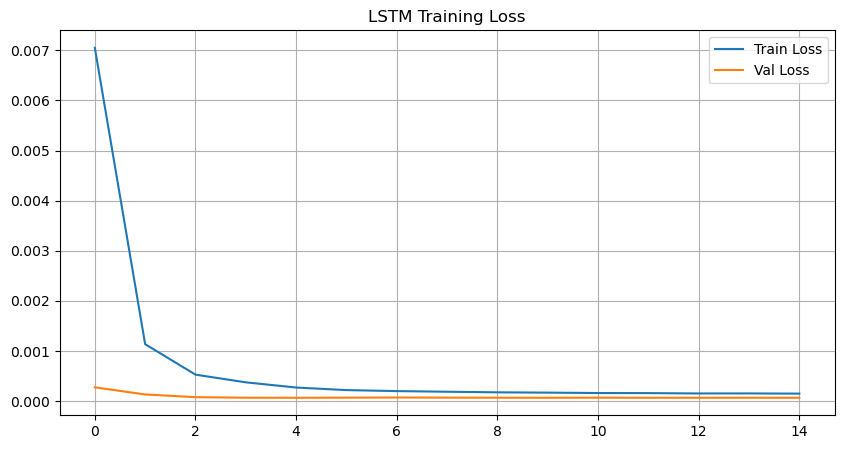

In [10]:
#LTSM Build
model = models.Sequential([
    layers.Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    layers.LSTM(32, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=15,
    batch_size=32,
    verbose=1
)

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Training Loss')
plt.legend()
plt.savefig("../images/lstm_training_curve.png")
plt.show()

In [11]:
#LSTM evaluations
y_pred_lstm = model.predict(X_test_lstm).flatten()

lstm_metrics = compute_regression_metrics(y_test_lstm, y_pred_lstm)
lstm_dir_acc = directional_accuracy(y_test_lstm, y_pred_lstm)

print("LSTM Metrics:", lstm_metrics)
print(f"Directional Accuracy: {lstm_dir_acc:.2%}")

 1/56 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step

18/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  

36/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


LSTM Metrics: {'RMSE': np.float64(0.021962368050795756), 'MAE': 0.010625985694445502, 'MAPE': np.float64(47043309.64492173), 'R2': -1.9863568474182483}
Directional Accuracy: 46.98%


In [12]:
summary_rows = []

summary_rows.append(
    {"Model": "Naive",
     **baseline_metrics,
     "DirAcc": baseline_dir_acc}
)

summary_rows.append(
    {"Model": "LinearRegression",
     **lr_test_metrics,
     "DirAcc": lr_dir_acc}
)

summary_rows.append(
    {"Model": "RandomForest",
     **rf_test_metrics,
     "DirAcc": rf_dir_acc}
)

summary_rows.append(
    {"Model": "ARIMA(1,0,1)",
     **arima_metrics,
     "DirAcc": arima_dir_acc}
)

summary_rows.append(
    {"Model": "LSTM",
     **lstm_metrics,
     "DirAcc": lstm_dir_acc}
)

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("../data/final_metrics.csv")
summary_df.head()

,Model,RMSE,MAE,MAPE,R2,DirAcc
0,Naive,1.694052e-02,1.160951e-02,5.502865e+07,-0.766366,0.509162
1,LinearRegression,1.914564e-07,1.411566e-07,6.262626e+02,1.000000,1.000000
2,RandomForest,1.171947e-03,8.215782e-05,4.043183e+05,0.991546,0.999445
3,"ARIMA(1,0,1)",1.088510e-02,7.145005e-03,3.433071e+07,-0.000894,0.545656
4,LSTM,2.196237e-02,1.062599e-02,4.704331e+07,-1.986357,0.469791


/tmp/ipykernel_4825/602907317.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(summary_df["Model"], rotation=45, ha="right")
/tmp/ipykernel_4825/602907317.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(summary_df["Model"], rotation=45, ha="right")


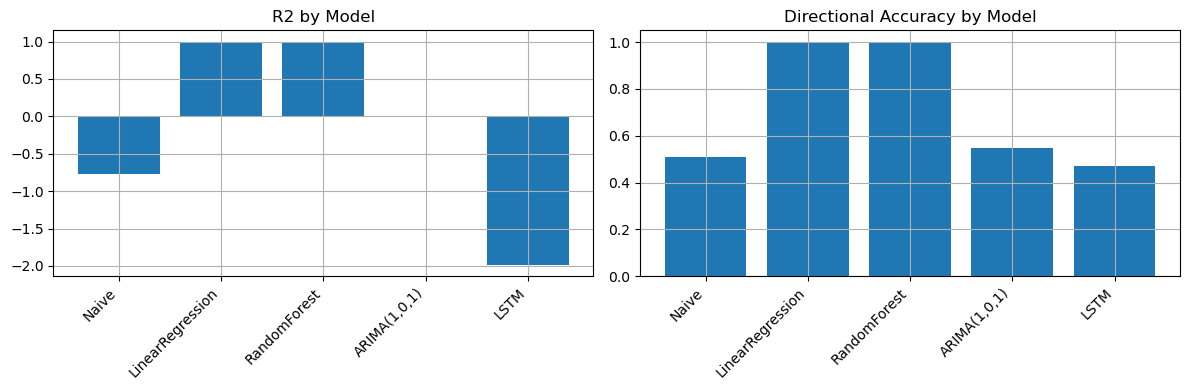

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(summary_df["Model"], summary_df["R2"])
axes[0].set_title("R2 by Model")
axes[0].set_xticklabels(summary_df["Model"], rotation=45, ha="right")

axes[1].bar(summary_df["Model"], summary_df["DirAcc"])
axes[1].set_title("Directional Accuracy by Model")
axes[1].set_xticklabels(summary_df["Model"], rotation=45, ha="right")

plt.tight_layout()
plt.savefig("../images/R2_Accuracy.png")
plt.show()